<h1 align="center">
	Quantum Phase Estimation
</h1>

- Quantum Phase Estimation is a quantum algorithm that estimates the phase of a unitary operator. Phase estimation plays a very important role in a number of quantum algorithms such as Shor’s algorithm. 
- Quantum Phase estimation is essentially a quantum circuit consisting of two sets of qubits. The first set consists of counting qubits that are used to control unitary operations and the second set whom the unitary operations are applied to. 

In [1]:
import numpy as np
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, BasicAer
from qiskit.circuit.library import QFT
from IPython.core.display import Image, display

<img src="figures/qpe.png" alt="drawing" width="800"/>


The goal of quantum phase estimation is to determine the phase $\theta$ applied by a unitary operator $U$ on its eigenstate $\vert\psi\rangle$ such that

$$U\vert\psi\rangle = e^{2\pi i\theta}\vert\psi\rangle$$

This is done in four main steps.

1. First, we begin by creating a superposition of all $2^n$ computational basis states on the $n$ measurement qubits by applying a Hadamard ($H$) gate on each qubit starting off in the state $\vert0\rangle^{\otimes n}$. We also initialize the target qubits (in this case only one) into an eigenstate $\vert\psi\rangle$ of the unitary operator $U$. Here, the exponent $\otimes n$ means that we have a tensor product of the states of $n$ qubits. 

2. Second, we apply the unitary operator $U$ with various powers onto the target qubits (in this case only one) by controlling it with each of the different measurement qubits. The schematic above shows the ordering and respective powers.

3. Third, we apply an inverse quantum Fourier transform on the $n$ measurement qubits.

4. Finally, we measure the $n$ qubits and read out $2^n\theta$.


$\textbf{STEP 1: PUT THE COUNTING QUBITS IN TO SUPERPOSITION}$

We will need to initialize our qubits as described above by applying a Hadamard gate on each of the $n$ measurement qubits. We will also set the target qubit to $\vert1\rangle$, since that is the eigenstate onto which the unitary operator $U$ will be applied. 

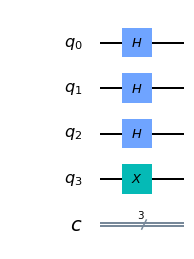

In [2]:
#INITIALISE THE QUANTUM AND CLASSICAL REGISTERS
q = QuantumRegister(4,'q')
c = ClassicalRegister(3,'c')
circuit1 = QuantumCircuit(q,c)

#PUT THE COUNTING QUBITS IN TO SUPERPOSITION
circuit1.h(q[0])
circuit1.h(q[1])
circuit1.h(q[2])
circuit1.x(q[3]) # Flips Q[3] to 1
circuit1.draw('mpl')


$\textbf{STEP 2: APPLY UNITARY OPERATIONS TO THE SECOND SET}$


The main part of the circuit is to apply unitary operations on the second set.

- These unitary operations are essentially just controlled phase rotations of a specific angle. This angle is the phase that we wish to estimate. The first counting qubit will do 1 rotation while the second will do 2 rotations and the third will do 4 rotations and so on. 



- For example lets say we have 4 qubits Q0 to Q3. The first 3 are the counting qubits and the 4th qubit is the qubit we wish to apply phase rotations to.The phase we wish to encode is pi/2. The first 3 qubits are put in to superposition. Next Q0 will control 1 phase rotation on Q3. Then Q1 will do 2 phase rotations on Q3 and Q2 will do 4 phase rotations on Q3. Note that each rotation will rotate Q3’s phase by pi/2. 
- The function implements the unitary operator described above by using `Qiskit`'s controlled-$u_1$ gate. The matrix for the $u_1$ gate is

$$u_1 = \begin{bmatrix}1 & 0\\ 0 & e^{i\theta}\end{bmatrix}$$

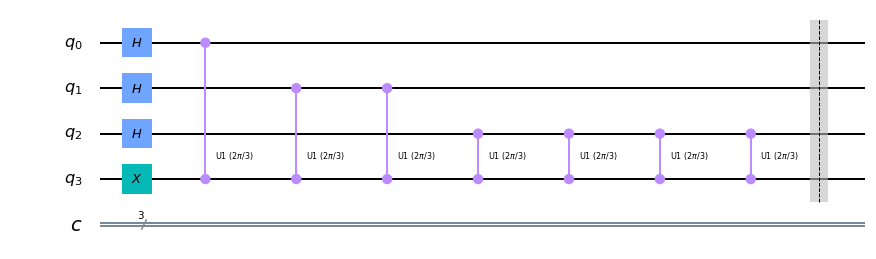

In [3]:
pi= np.pi
angle = 2*pi/3 #The phase angle we wish to encode

actual_phase = angle/(2*pi) # This is the actual phase rotation ie 0.5 would be half a rotation. 
                            #Our expected rotation will be 0.33.  

circuit1.cu1(angle, q[0], q[3]);#where angle is the rotation amount, q[0] is the control qubit and q[3] is the target qubit

circuit1.cu1(angle, q[1], q[3]); 
circuit1.cu1(angle, q[1], q[3]);

circuit1.cu1(angle, q[2], q[3]);
circuit1.cu1(angle, q[2], q[3]);
circuit1.cu1(angle, q[2], q[3]);
circuit1.cu1(angle, q[2], q[3]);

circuit1.barrier()
circuit1.draw('mpl')

$\textbf{STEP 3: APPLY AN INVERSE QFT}$
- After these rotations an inverse QFT is applied to the counting qubits and they are measured. 



- A QFT or Quantum Fourier Transform is a circuit that transforms the state of the qubit from the computational basis to the Fourier basis. However in phase estimation we use the inverse QFT which puts the state in the Fourier basis in to the computational basis so we can measure it. 


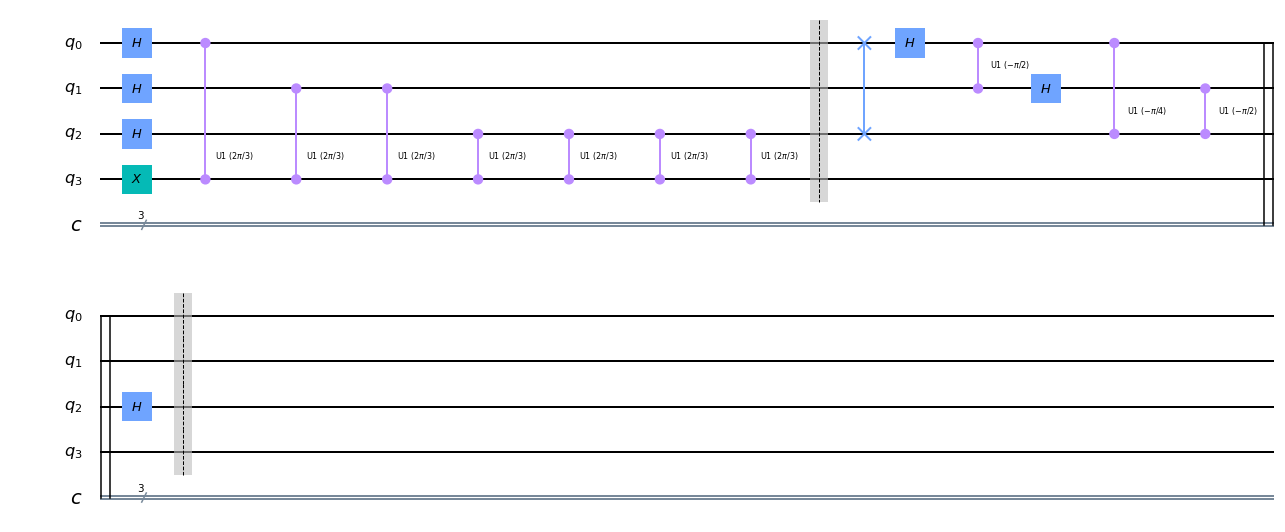

In [4]:
circuit1.swap(q[0],q[2])
circuit1.h(q[0])
circuit1.cu1(-pi/2, q[0], q[1]);
circuit1.h(q[1])
circuit1.cu1(-pi/4, q[0], q[2]);
circuit1.cu1(-pi/2, q[1], q[2]);
circuit1.h(q[2])

circuit1.barrier()
circuit1.draw('mpl')

$\textbf{STEP 4: MEASURE THE COUNTING QUBITS}$

- After we have applied the inverse QFT we measure the qubits. If we have encoded a phase of pi/2 in to Q3 then we should get the binary value ‘010’ which is 2.

- To estimate the phase we use the following formula:


$$
\theta_{\text {estimated}}=\frac{M}{2^{n}}
$$


Where $\theta$ is the estimated phase, $\mathrm{M}$ is the measured value, and $\mathrm{n}$ is the number of counting qubits. 

- As such from the measurement above:


$$
\frac{2}{2^{3}}=0.25
$$


Which is correct since $\mathrm{pi} / 2$ corresponds to a quarter rotation or $0.25 .$

In [5]:
#### Measuring counting qubits ####
circuit1.measure(q[0],0)
circuit1.measure(q[1],1)
circuit1.measure(q[2],2)

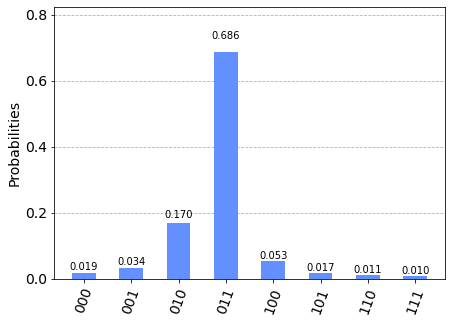

In [6]:
from qiskit.visualization import plot_histogram
simulator = Aer.get_backend('qasm_simulator')
counts = execute(circuit1, backend=simulator, shots=1000).result().get_counts(circuit1)
plot_histogram(counts)

In [7]:
maxcounts = max(counts, key=counts.get) # take the most often obtaned result
print(maxcounts)
a=int(maxcounts, 2)#convert to decimal
print(a)

011
3


In [8]:
print('Most frequent measurement: ',a,'\n')
n=3
phase = a/(2**n)# The calculation used to estimate the phase


print('Actual phase is: ',actual_phase)
print('Estimated phase is: ',phase)

Most frequent measurement:  3 

Actual phase is:  0.3333333333333333
Estimated phase is:  0.375
